In [1]:
# import that packages...
from pathlib import Path

import mne
import mne.io
# import mne_bids
import numpy as np
import plotly.express as px
import q1k_sync_tools as qst

In [2]:
%matplotlib qt

In [3]:
# set some common parameters...
PATH_TO_YOUR_EEG_FILE = Path('../q1k-pilot/s06_v2_eeg/s06_v2_as_20230404_014928.mff')
assert PATH_TO_YOUR_EEG_FILE.exists()

PATH_TO_YOUR_ET_FILE = Path('../q1k-pilot/s06_v2_eyetracking/s06v2_as.asc')
assert PATH_TO_YOUR_ET_FILE.exists()

subject_id = '0006' #this is not used for anything right now..
task_code = 'as' # this is currently used to determine the task specific sync event sequence.. options: as, fsp, go, mmn, nsp, plr, rest, ssaep, ssvep, vs
bids_root = '.' # this will eventually determine the root directory for the BIDS subject folders

In [4]:
#read EEG mff data and convert it to a dataframe..
eeg_raw = mne.io.read_raw_egi(PATH_TO_YOUR_EEG_FILE)
eeg_raw_df = eeg_raw.to_data_frame()


Reading EGI MFF Header from c:\Users\shuber10\Documents\github_repos\q1k_eeget_init\..\q1k-pilot\s06_v2_eeg\s06_v2_as_20230404_014928.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...


In [5]:
# peak... at the eeg channel types
eeg_types = eeg_raw.get_channel_types()
np.unique(eeg_types)

array(['eeg', 'stim'], dtype='<U4')

In [6]:
#get the EEG events from the stim stim channel
eeg_events = mne.find_events(eeg_raw, shortest_event = 1)

#create the event dictionary..
eeg_event_dict = qst.get_event_dict(eeg_raw,eeg_events)

783 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


In [7]:
# handle task specific EEG event interpretation..
eeg_events, eeg_stims, eeg_iti, eeg_event_dict = qst.eeg_event_test(eeg_events, eeg_event_dict, task_name=task_code)

Number of stimulus onset DIN events: 52


In [8]:
# peak... at the EEG event scatter plot.. event time stamp by label index
fig=px.scatter(x=eeg_events[:,0],y=eeg_events[:,2])
fig.show()

In [9]:
#read the asc eye tracking data and convert it to a dataframe...
et_raw = mne.io.read_raw_eyelink (PATH_TO_YOUR_ET_FILE)
et_raw_fresh=et_raw.copy() #make a fresh copy for later
et_raw_df = et_raw.to_data_frame()

#get the events from the annotation structure
et_annot_events, et_annot_event_dict = mne.events_from_annotations(et_raw)

Loading ..\q1k-pilot\s06_v2_eyetracking\s06v2_as.asc
Pixel coordinate data detected.
Pass `scalings=dict(eyegaze=1e3)` when using plot method to make traces more legible.
Pupil-size area reported.
There are 52 recording blocks in this file. Times between blocks will be annotated with bad_rec_gap.
Used Annotations descriptions: ['ANTI-SACCADE_TRIAL', 'CORRECTIVE-SACCADE_TRIAL', 'DISPLAY_FIXATION', 'DISTRACTOR_OFFSET', 'GAZE_TO_DISTRACTOR', 'GAZE_TO_FIX', 'GAZE_TO_TARGET', 'INVALID_TRIAL', 'ONSET_DISTRACTOR', 'ONSET_REWARD', 'PREDICT_TARGET_GAZE', 'PRO-SACCADE_TRIAL', 'TARGET_ONSET', 'TRACKER_TIME 2 2977896.278', 'TRACKER_TIME 3 3037899.929', 'TRACKER_TIME 4 3097924.93', 'TRACKER_TIME 5 3157959.299', 'TRIAL_END', 'blink_R', 'fixation_R', 'saccade_R']


In [10]:
# peak... at the ET channel types
et_types = et_raw.get_channel_types()
np.unique(et_types)

array(['eyegaze', 'misc', 'pupil', 'stim'], dtype='<U7')

In [11]:
#handle task specific ET event interpretation..
et_event_raw_df, et_events, et_stims, et_iti = qst.et_event_test(et_raw_df,task_name=task_code)

Number of eye-tracking stimulus onset DIN events: 52


c:\Users\shuber10\Documents\github_repos\q1k_eeget_init\q1k_sync_tools.py:309: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
# peak... at the ET event scatter plot.. event time stamp by DIN index
fig=px.scatter(x=et_events['index'], y=et_events['DIN_diff'])
fig.show()

In [13]:
# peak... at the time offset between the matched events in the EEG and ET recording 
qst.show_sync_offsets(eeg_stims,et_stims)

In [14]:
# combine the EEG and ET recordings given the matched event times.. then create a dataframe copy..
eeg_et_raw = qst.eeg_et_combine(eeg_raw, et_raw, eeg_stims, et_stims)
eeg_et_raw_df = eeg_et_raw.to_data_frame()

Zero order coefficient: -319.6338421672035 
First order coefficient: 1.0000094245436744
Linear correlation computed as R=1.000 and p=5.81e-262
Drift rate: 9.4 μs/s (total drift over 252.5 s recording: 2.4 ms)
Cropping -319.634 s from the start of other
Resampling other
Reading 0 ... 253586  =      0.000 ...   253.586 secs...
781 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
781 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Cropping 1.103 s from the end of other
Creating RawArray with float64 data, n_channels=164, n_times=252486
    Range : 0 ... 252485 =      0.000 ...   252.485 secs
Ready.


In [50]:
#get the EEG/ET events from the stim stim channel
eeg_et_events = mne.find_events(eeg_et_raw, shortest_event = 1)

#create the EEG/ETevent dictionary..
eeg_et_event_dict = qst.get_event_dict(eeg_et_raw,eeg_et_events)

781 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


In [26]:
np.unique([annot["description"] for annot in et_raw.annotations])

array(['ANTI-SACCADE_TRIAL', 'CORRECTIVE-SACCADE_TRIAL',
       'DISPLAY_FIXATION', 'DISTRACTOR_OFFSET', 'GAZE_TO_DISTRACTOR',
       'GAZE_TO_FIX', 'GAZE_TO_TARGET', 'INVALID_TRIAL',
       'ONSET_DISTRACTOR', 'ONSET_REWARD', 'PREDICT_TARGET_GAZE',
       'PRO-SACCADE_TRIAL', 'TARGET_ONSET', 'TRACKER_TIME 2 2977896.278',
       'TRACKER_TIME 3 3037899.929', 'TRACKER_TIME 4 3097924.93',
       'TRACKER_TIME 5 3157959.299', 'TRIAL_END', 'bad_rec_gap',
       'blink_R', 'fixation_R', 'saccade_R'], dtype='<U26')

In [94]:
blink_annot_list = [annot for annot in et_raw.annotations if annot['description'] in ['blink_R', 'bad_rec_gap', 'ONSET_DISTRACTOR']]  #  'fixation_R', 'saccade_R'

In [112]:
import pandas as pd
df = pd.DataFrame(blink_annot_list)
annots = mne.Annotations(onset=df.onset, duration=df.duration, description=df.description)
eeg_et_raw.set_annotations(annots)

<RawArray | 164 x 252486 (252.5 s), ~316.1 MB, data loaded>

In [122]:
distractor_onsets = mne.events_from_annotations(eeg_et_raw, {'ONSET_DISTRACTOR':1})[0]

Used Annotations descriptions: ['ONSET_DISTRACTOR']


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.4s finished


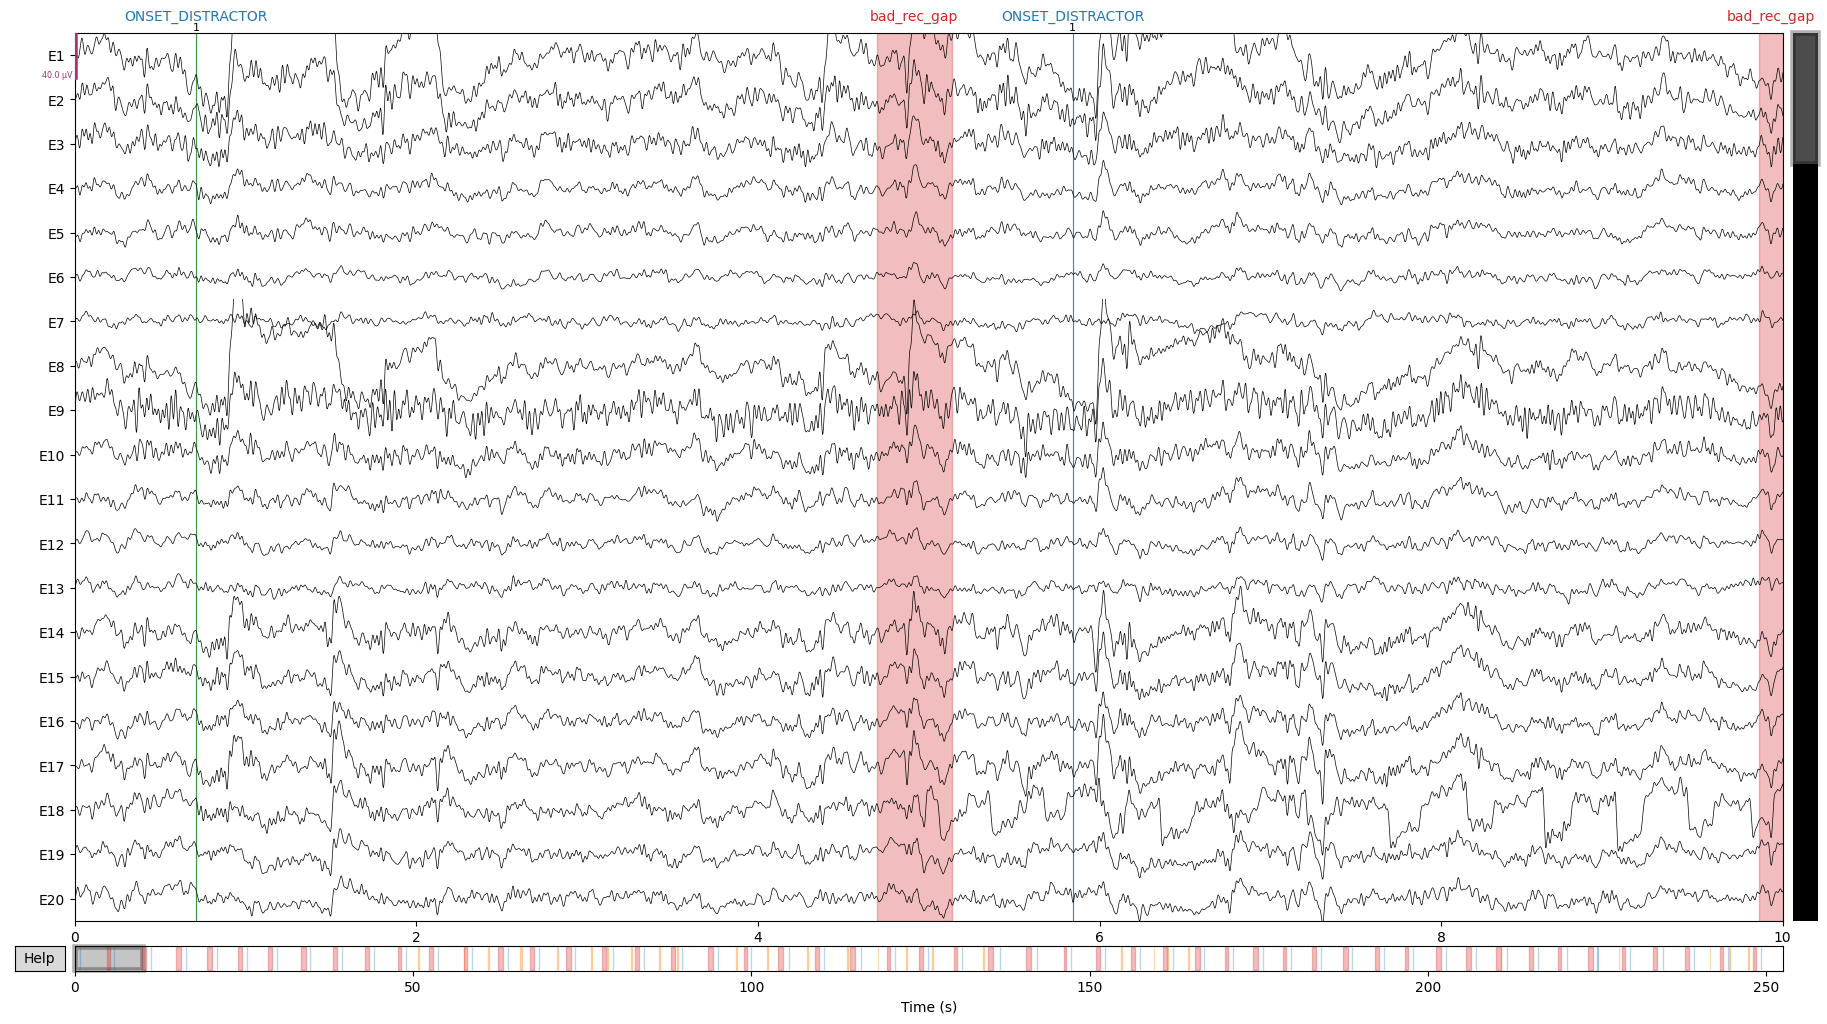

Channels marked as bad:
none


In [123]:
scalings=dict(eyegaze=1e3)
eeg_et_raw.copy().pick(['eeg','eyetrack','misc']).filter(1,40, picks=['eeg']).plot(scalings=scalings, events=distractor_onsets, event_id={1:'distractor_onset'}, event_color='g')

In [18]:
# create event list froma  specific event type of interest...
mask = np.isin(eeg_et_events[:,2],[eeg_et_event_dict['plro']])
eeg_et_events = eeg_et_events[mask]

In [20]:
# epoch the continuous data to the events of interest...
eeg_et_epochs = mne.Epochs(eeg_et_raw, eeg_et_events, tmin=-1, tmax=5)

Not setting metadata
32 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [25]:
# plot the EEG/ET epoch scroll
scalings=dict(pupil=1e2)
eeg_et_epochs.plot(n_epochs=5,scalings=scalings)

Using data from preloaded Raw for 32 events and 6001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 5 events and 6001 original time points ...
Using data from preloaded Raw for 3 events and 6001 original time points ...


In [26]:
# export the sync'd continuous data to BIDS format... this seems to have an issue with the 'eyegaze' channel type.. errors
bids_path = mne_bids.BIDSPath(subject=subject_id, task=task_code, root=bids_root)
mne_bids.write_raw_bids(eeg_et_raw, bids_path, events=eeg_et_events, event_id=eeg_et_event_dict, overwrite=True, allow_preload=True, format='EDF')

KeyError: 'eyegaze'

In [ ]:
#show the stimulus DIN event inter-trial intervals... this should be replicated in the eye-tracking recording..
fig = px.line(y=eeg_iti)
fig.show()